# Deep neural net optimization
Hopefully, the performance of decision tree based models can be improved upon using a deep neural network. The plan is to start small and train on one geospatial bin only. If the model shows promise, it will then be scaled to make predictions for all of California.

### Goal: 
Optimize and test the performance of a deep neural network on one California geospatial bin.

### Plan:
1. Prep data from one geospatial bin for input into neural network
2. Generate 'Cassandra' model -> attempt to over fit and 'memorize' the training data. This will prove that the data is feature rich enough and a the network is complex enough to learn a function which successfully maps input to output.
3. If step 2 is successful, regularize model to increase generalizability.
4. If step 3 is successful, scale model to predict wilfire risk for all 410 California geospatial bins.

# Notebook setup

In [1]:
from numpy.random import seed
seed(42)

import logging

import tensorflow as tf

# Note: tf 2.1.0 give warning about model weight format when
# using class weights. This is the only way to silence without
# updating
tf.get_logger().setLevel(logging.ERROR)
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math
import pandas as pd

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import load_model
from tensorflow.python.client import device_lib

# Note: sklearn forces depreciation warnings
# This is the only way to silence them without updating
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_objective_2D #, plot_histogram
from skopt.utils import use_named_args

In [5]:
import helper_functions.data_functions as data_functions
import helper_functions.plotting_functions as plotting_functions

In [6]:
import sys
print(f"Python {sys.version}")
print()
print(f"Pandas {pd.__version__}")
print(f"Tensorflow {tf.__version__}")
print(f"Keras {keras.__version__}")
print(f"SciKit Learn {sklearn.__version__}")
print()

devices = device_lib.list_local_devices()

if 'GPU' in ('').join(str(devices)):
    print("tf accessable GPU found: "+devices[-2].physical_device_desc)

Python 3.7.7 (default, Mar 23 2020, 22:36:06) 
[GCC 7.3.0]

Pandas 1.0.3
Tensorflow 2.1.0
Keras 2.2.4-tf
SciKit Learn 0.22.1

tf accessable GPU found: device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1


In [7]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [8]:
training_file = '../training_data_pipeline/data/stratified_training_data/1992-2015_california_features_added_n500000_ks_pval0.3.1.parquet'
validation_file = '../training_data_pipeline/data/stratified_training_data/1992-2015_california_features_added_n500000_ks_pval0.3.2.parquet'
test_file = '../training_data_pipeline/data/stratified_training_data/1992-2015_california_features_added_n500000_ks_pval0.3.3.parquet'

metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    data_functions.matthews_correlation
]

dim_learning_rate = Real(
    low=1e-5, 
    high=1e-1, 
    prior='log-uniform',
    name='learning_rate'
)

dim_hidden_layers = Integer(
    low=5,
    high=100, 
    name='hidden_layers'
)

dim_neurons_per_layer = Integer(
    low=10, 
    high=100, 
    name='neurons_per_layer'
)

dim_dropout_rate = Real(
    low=0.01, 
    high=0.5, 
    name='dropout_rate'
)

dim_l2_lambda = Real(
    low=0.001, 
    high=0.1, 
    name='l2_lambda'
)

dim_class_0_weight = Real(
    low=0.1,
    high=5,
    name='class_0_weight'
)

dim_class_1_weight = Real(
    low=10,
    high=15,
    name="class_1_weight"
)

dimensions = [
    dim_learning_rate,
    dim_hidden_layers,
    dim_neurons_per_layer,
    dim_dropout_rate,
    dim_l2_lambda,
    dim_class_0_weight,
    dim_class_1_weight
]

default_parameters = [0.001, 10, 50, 0.25, 0.05, 0.5, 12]

#path_best_model = '../trained_models/best_skopt_MLP.keras'
best_matthews_correlation = -1.0

In [9]:
training_data = pd.read_parquet(training_file)
validation_data = pd.read_parquet(validation_file)
testing_data = pd.read_parquet(test_file)

In [10]:
# One hot encode month

months = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'Septermber',
    'October',
    'November',
    'December'
]


# onehot encode month
onehot_encoder = OneHotEncoder(sparse=False)

# extract month from date column and convert to int
month = np.array(pd.DatetimeIndex(training_data['date']).month).reshape(-1, 1)
month = month.astype('int32')

# onehot encode
onehot_month = onehot_encoder.fit_transform(month).astype('int32')

# convert one hot encoded months to dataframe
onehot_month_df = pd.DataFrame(onehot_month, columns = months)

# reset indexes, set dtypes and concatenate one hot encoded months 
# back to orignal dataframe
onehot_month_df.reset_index(drop = True, inplace = True)
onehot_month_df = onehot_month_df.astype('int32')
training_data.reset_index(drop = True, inplace = True)
training_data = pd.concat([training_data, onehot_month_df], axis = 1)
training_data.drop('date', axis=1, inplace=True)


# extract month from date column and convert to int
month = np.array(pd.DatetimeIndex(validation_data['date']).month).reshape(-1, 1)
month = month.astype('int32')

# onehot encode
onehot_month = onehot_encoder.fit_transform(month).astype('int32')

# convert one hot encoded months to dataframe
onehot_month_df = pd.DataFrame(onehot_month, columns = months)

# reset indexes, set dtypes and concatenate one hot encoded months 
# back to orignal dataframe
onehot_month_df.reset_index(drop = True, inplace = True)
onehot_month_df = onehot_month_df.astype('int32')
validation_data.reset_index(drop = True, inplace = True)
validation_data = pd.concat([validation_data, onehot_month_df], axis = 1)
validation_data.drop('date', axis=1, inplace=True)



# extract month from date column and convert to int
month = np.array(pd.DatetimeIndex(testing_data['date']).month).reshape(-1, 1)
month = month.astype('int32')

# onehot encode
onehot_month = onehot_encoder.fit_transform(month).astype('int32')

# convert one hot encoded months to dataframe
onehot_month_df = pd.DataFrame(onehot_month, columns = months)

# reset indexes, set dtypes and concatenate one hot encoded months 
# back to orignal dataframe
onehot_month_df.reset_index(drop = True, inplace = True)
onehot_month_df = onehot_month_df.astype('int32')
testing_data.reset_index(drop = True, inplace = True)
testing_data = pd.concat([testing_data, onehot_month_df], axis = 1)
testing_data.drop('date', axis=1, inplace=True)

In [11]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449258 entries, 0 to 449257
Data columns (total 46 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   lat               449258 non-null  float32
 1   lon               449258 non-null  float32
 2   month             449258 non-null  int64  
 3   mean_air_2m       449258 non-null  float32
 4   mean_apcp         449258 non-null  float32
 5   mean_rhum_2m      449258 non-null  float32
 6   mean_dpt_2m       449258 non-null  float32
 7   mean_pres_sfc     449258 non-null  float32
 8   mean_uwnd_10m     449258 non-null  float32
 9   mean_vwnd_10m     449258 non-null  float32
 10  mean_vis          449258 non-null  float32
 11  mean_cloud_cover  449258 non-null  float32
 12  max_air_2m        449258 non-null  float32
 13  max_apcp          449258 non-null  float32
 14  max_rhum_2m       449258 non-null  float32
 15  max_dpt_2m        449258 non-null  float32
 16  max_pres_sfc      44

In [12]:
# Form np arrays of labels and features.
train_labels = np.array(training_data.pop('ignition'))
val_labels = np.array(validation_data.pop('ignition'))
testing_labels = np.array(testing_data.pop('ignition'))

train_features = np.array(training_data)
val_features = np.array(validation_data)
testing_features = np.array(testing_data)

In [13]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
testing_features = scaler.transform(testing_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Testing labels shape:', testing_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Testing features shape:', testing_features.shape)

Training labels shape: (449258,)
Validation labels shape: (449257,)
Testing labels shape: (449258,)
Training features shape: (449258, 45)
Validation features shape: (449257, 45)
Testing features shape: (449258, 45)


In [14]:
ignition_count = sum(train_labels)
no_ignition_count = len(train_labels) - ignition_count

initial_bias = np.log([ignition_count/no_ignition_count])
output_bias = tf.keras.initializers.Constant(initial_bias)

EPOCHS = 50
BATCH_SIZE = 10000
STEPS_PER_EPOCH = (len(train_features) * 1) // BATCH_SIZE
VALIDATION_STEPS = (len(val_features) * 1) // BATCH_SIZE

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_matthews_correlation', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [15]:
def make_model(
    output_bias,
    learning_rate,
    hidden_layers,
    neurons_per_layer,
    dropout_rate,
    l2_lambda
):    
    # Define the keras model
    model = keras.Sequential()
    
    # Add input layer
    model.add(keras.layers.Dense(
        neurons_per_layer, 
        activation = 'relu', 
        input_dim = train_features.shape[-1],
    ))

    # Add fully connected hidden layers
    for i in range(hidden_layers):
        model.add(keras.layers.Dense(
            neurons_per_layer,
            bias_initializer=keras.initializers.VarianceScaling(
                scale=1.0,
                mode='fan_in', 
                distribution='normal', 
                seed=None
            ),
            kernel_regularizer=keras.regularizers.l2(l2_lambda),
            activation = 'relu')
        )
    
    # Add dropout layer
    model.add(keras.layers.Dropout(dropout_rate))
    
    # Add output layer
    model.add(keras.layers.Dense(
        1, 
        activation = 'sigmoid', 
        bias_initializer = output_bias
    ))

    model.compile(
        optimizer=keras.optimizers.Adam(lr=learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )

    return model

#run_num = 1

@use_named_args(dimensions=dimensions)
def fitness(
    learning_rate,
    hidden_layers,
    neurons_per_layer,
    dropout_rate,
    l2_lambda,
    class_0_weight,
    class_1_weight
):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    class_weight = {0: class_0_weight, 1: class_1_weight}
    
#     # Print the hyper-parameters.
#     print('learning rate: {0:.1e}'.format(learning_rate))
#     print('hidden layers:', hidden_layers)
#     print('neurons per layer:', neurons_per_layer)
#     print('dropout rate: {}'.format(np.round(dropout_rate,2)))
#     print('l2 lambda: {0:.1e}'.format(l2_lambda))
#     print('class weight: {}, {}'.format(np.round(class_weight[0],1), np.round(class_weight[1],2)))
#     print()
    
    # Create the neural network with these hyper-parameters.
    model = make_model(
        output_bias,
        learning_rate = learning_rate,
        hidden_layers = hidden_layers,
        neurons_per_layer = neurons_per_layer,
        dropout_rate = dropout_rate,
        l2_lambda = l2_lambda
    )
    
#     model.summary()
#     print()

    # Dir-name for the TensorBoard log-files.
#     log_dir = log_dir_name(
#         learning_rate,
#         hidden_layers,
#         neurons_per_layer,
#         dropout_rate,
#         l2_lambda,
#         class_0_weight,
#         class_1_weight
#     )
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
#     callback_log = TensorBoard(
#         log_dir=log_dir,
#         histogram_freq=0,
#         write_graph=True,
#         write_grads=False,
#         write_images=False
#     )
   
    # Use Keras to train the model.
    history = model.fit(
        train_features,
        train_labels,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks = [early_stopping],
        validation_data=(val_features, val_labels),
        validation_steps=VALIDATION_STEPS,
        class_weight=class_weight,
        workers=8,
        verbose=0
    )

    # Get MCC for training run
    matthews_correlation = history.history['val_matthews_correlation'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_matthews_correlation

    # If the MCC of the saved model is improved ...
    if matthews_correlation > best_matthews_correlation:
        # Save the new model to harddisk.
        #model.save(path_best_model)
        
        # Update the classification accuracy.
        best_matthews_correlation = matthews_correlation
        
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    #run_num += 1
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST MCC, we need to 
    # negate this number so it can be minimized.
    return -matthews_correlation

In [16]:
search_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI', # Expected Improvement.
    n_calls=100,
    x0=default_parameters
)

In [17]:
dim_names = [
    'learning_rate',
    'hidden_layers',
    'neurons_per_layer',
    'dropout_rate',
    'l2_lambda',
    'class_0_weight',
    'class_1_weight'
]

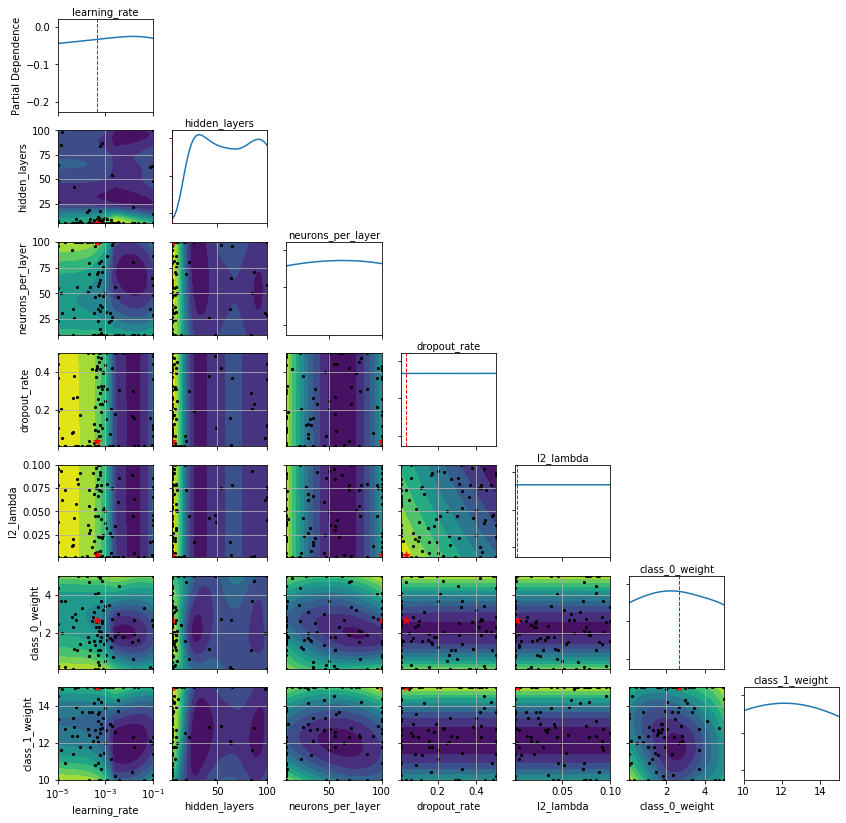

In [18]:
fig, ax = plot_objective(result=search_result, dimension_names=dim_names)

In [19]:
space = search_result.space
winning_hyperparams = space.point_to_dict(search_result.x)
winning_hyperparams

{'learning_rate': 0.0004317792985376744,
 'hidden_layers': 5,
 'neurons_per_layer': 100,
 'dropout_rate': 0.03875353834458198,
 'l2_lambda': 0.003690201373294293,
 'class_0_weight': 2.6709153441949938,
 'class_1_weight': 15.0}

In [20]:
# 0.001, 2, 30, 0.5, 0.1, 0.5, 15 defaults

In [21]:
learning_rate = winning_hyperparams['learning_rate']
#learning_rate = 0.001
hidden_layers = winning_hyperparams['hidden_layers']
units_per_layer = winning_hyperparams['neurons_per_layer']
dropout_rate = winning_hyperparams['dropout_rate']
l2_lambda = winning_hyperparams['l2_lambda']
#l2_lambda = 0.05
class_0_weight = winning_hyperparams['class_0_weight']
#class_0_weight = 0.6
class_1_weight = winning_hyperparams['class_1_weight']

initial_bias = np.log([ignition_count/no_ignition_count])
output_bias = tf.keras.initializers.Constant(initial_bias)
    
class_weight = {0: class_0_weight, 1: class_1_weight}

EPOCHS = 1000
BATCH_SIZE = 10000
STEPS_PER_EPOCH = (len(training_data) * 1) // BATCH_SIZE
VALIDATION_STEPS = (len(validation_data) * 1) // BATCH_SIZE

In [22]:
# Define the keras model
model = keras.Sequential()

# Add input layer
model.add(keras.layers.Dense(
    units_per_layer, 
    activation = 'relu', 
    input_dim = train_features.shape[-1],
))

# Add fully connected hidden layers
for i in range(hidden_layers):
    model.add(keras.layers.Dense(
        units_per_layer,
        bias_initializer=keras.initializers.VarianceScaling(
            scale=1.0,
            mode='fan_in', 
            distribution='normal', 
            seed=None
        ),
        kernel_regularizer=keras.regularizers.l2(l2_lambda),
        activation = 'relu')
    )

# Add dropout layer
model.add(keras.layers.Dropout(dropout_rate))

# Add output layer
model.add(keras.layers.Dense(
    1, 
    activation = 'sigmoid', 
    bias_initializer = output_bias
))

model.compile(
    optimizer=keras.optimizers.Adam(lr=learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics
)

In [23]:
history = model.fit(
    train_features,
    train_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    validation_steps=VALIDATION_STEPS,
    class_weight=class_weight,
    workers=8,
    verbose=0
)

#model.save('../trained_models/best_MLP.keras')

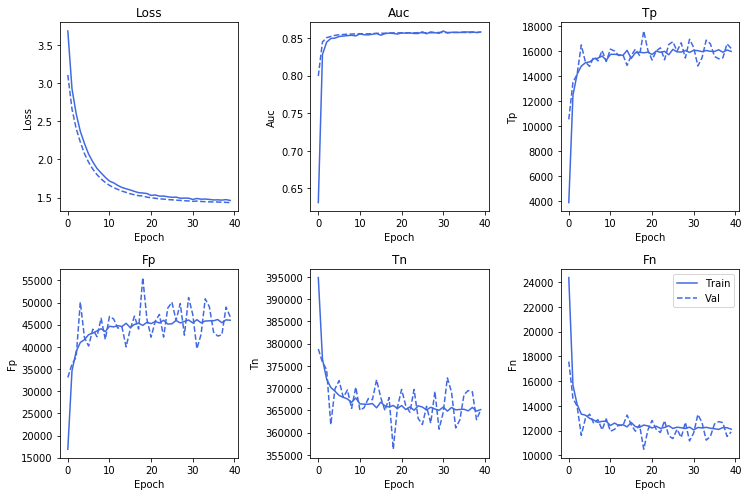

In [24]:
metric_names =  ['loss', 'auc', 'tp', 'fp', 'tn', 'fn']
filename = '../project_info/figures/deep_neural_net_learning_curves.png'
plotting_functions.plot_metrics(history, metric_names, filename)

In [25]:
train_predictions = model.predict(train_features)
validation_predictions = model.predict(val_features)
testing_predictions = model.predict(testing_features)

loss :  0.3681882080700423
tp :  17295.0
fp :  52109.0
tn :  368353.0
fn :  11501.0
accuracy :  0.85841095
precision :  0.24919313
recall :  0.60060424
auc :  0.85684204
matthews_correlation :  0.2925467

Training data prediction results
No fire (True Negatives):  368166
False alarms (False Positives):  52242
Fires missed (False Negatives):  11455
Fires detected (True Positives):  17395
Total fires:  28850

Test data prediction results
No fire (True Negatives):  368353
False alarms (False Positives):  52109
Fires missed (False Negatives):  11501
Fires detected (True Positives):  17295
Total fires:  28796


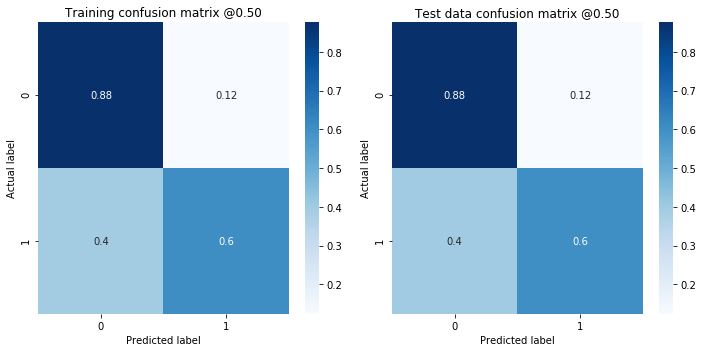

In [26]:
results = model.evaluate(
    testing_features,
    testing_labels, 
    verbose=0
)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
    
filename = '../project_info/figures/deep_neural_net_confusion_matrices.png'
plotting_functions.plot_cm(train_labels, train_predictions, testing_labels, testing_predictions, filename)

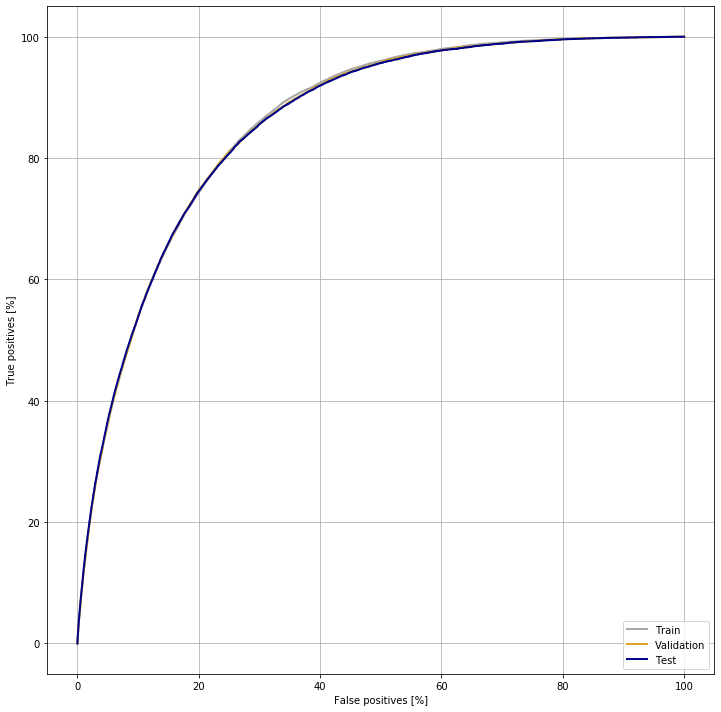

In [27]:
# plot ROC for all three datasets
plotting_functions.plot_roc("Train", train_labels, train_predictions, color='darkgray')
plotting_functions.plot_roc("Validation", val_labels, validation_predictions, color='goldenrod')
plotting_functions.plot_roc("Test", testing_labels, testing_predictions, color='darkblue')
plt.legend(loc='lower right')
plt.savefig('../project_info/figures/deep_neural_net_ROC.png', bbox_inches='tight')
plt.show()

In [30]:
training_data = pd.read_parquet(training_file)
testing_data = pd.read_parquet(test_file)

In [31]:
# One hot encode month

months = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'Septermber',
    'October',
    'November',
    'December'
]


# onehot encode month
onehot_encoder = OneHotEncoder(sparse=False)

# extract month from date column and convert to int
month = np.array(pd.DatetimeIndex(training_data['date']).month).reshape(-1, 1)
month = month.astype('int32')

# onehot encode
onehot_month = onehot_encoder.fit_transform(month).astype('int32')

# convert one hot encoded months to dataframe
onehot_month_df = pd.DataFrame(onehot_month, columns = months)

# reset indexes, set dtypes and concatenate one hot encoded months 
# back to orignal dataframe
onehot_month_df.reset_index(drop = True, inplace = True)
onehot_month_df = onehot_month_df.astype('int32')
training_data.reset_index(drop = True, inplace = True)
training_data = pd.concat([training_data, onehot_month_df], axis = 1)
training_data.drop('date', axis=1, inplace=True)


# extract month from date column and convert to int
month = np.array(pd.DatetimeIndex(testing_data['date']).month).reshape(-1, 1)
month = month.astype('int32')

# onehot encode
onehot_month = onehot_encoder.fit_transform(month).astype('int32')

# convert one hot encoded months to dataframe
onehot_month_df = pd.DataFrame(onehot_month, columns = months)

# reset indexes, set dtypes and concatenate one hot encoded months 
# back to orignal dataframe
onehot_month_df.reset_index(drop = True, inplace = True)
onehot_month_df = onehot_month_df.astype('int32')
testing_data.reset_index(drop = True, inplace = True)
testing_data = pd.concat([testing_data, onehot_month_df], axis = 1)
testing_data.drop('date', axis=1, inplace=True)

In [32]:
# Pick one spatial bin with fires
training_data = training_data[(training_data['lat'] == 39.19109) & (training_data['lon'] == -120.2230)]
testing_data = testing_data[(testing_data['lat'] == 38.90858) & (testing_data['lon'] == -120.1582)]

In [33]:
# Split into features and label as numpy arrays
train_labels = np.array(training_data.pop('ignition'))
train_features = np.array(training_data)

testing_labels = np.array(testing_data.pop('ignition'))
testing_features = np.array(testing_data)

# Scale
train_features = scaler.transform(train_features)
testing_features = scaler.transform(testing_features)

In [34]:
# Predict
train_predictions = model.predict(train_features)
test_predictions = model.predict(testing_features)

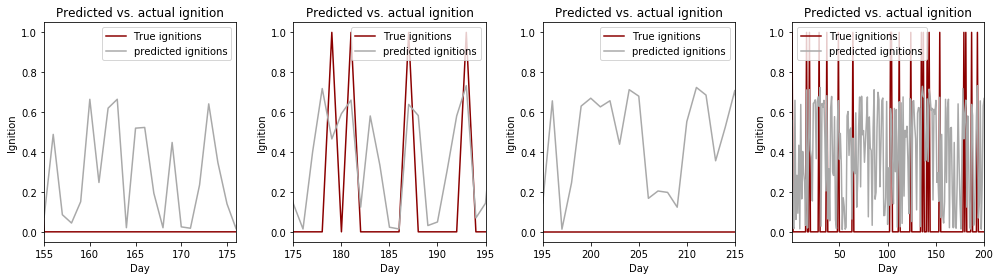

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(1,4,figsize=(14,4))

plt.subplot(1, 4, 1)

plt.plot(
    range(len(train_labels)), 
    train_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(train_labels)), 
    train_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(155,176)

plt.subplot(1, 4, 2)

plt.plot(
    range(len(train_labels)), 
    train_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(train_labels)), 
    train_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(175,195)

plt.subplot(1, 4, 3)

plt.plot(
    range(len(train_labels)), 
    train_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(train_labels)), 
    train_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(195,215)

plt.subplot(1, 4, 4)

plt.plot(
    range(len(train_labels)), 
    train_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(train_labels)), 
    train_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(1,200)

plt.tight_layout()
plt.savefig('../project_info/figures/deep_neural_net_training_predictions.png', bbox_inches='tight')
plt.show()

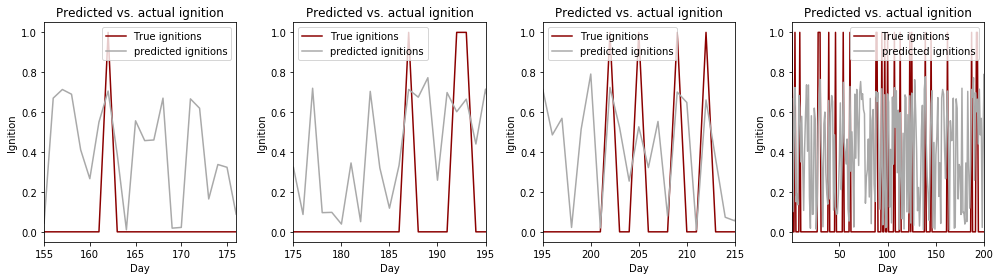

In [36]:
plt.subplots(1,4,figsize=(14,4))

plt.subplot(1, 4, 1)

plt.plot(
    range(len(testing_labels)), 
    testing_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(testing_labels)), 
    test_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(155,176)

plt.subplot(1, 4, 2)

plt.plot(
    range(len(testing_labels)), 
    testing_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(testing_labels)), 
    test_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(175,195)

plt.subplot(1, 4, 3)

plt.plot(
    range(len(testing_labels)), 
    testing_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(testing_labels)), 
    test_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(195,215)

plt.subplot(1, 4, 4)

plt.plot(
    range(len(testing_labels)), 
    testing_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(testing_labels)), 
    test_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(1,200)

plt.tight_layout()
plt.savefig('../project_info/figures/deep_neural_net_test_predictions.png', bbox_inches='tight')
plt.show()